# K-Nearest Neighbors

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from feature_scaler import *
from evaluation import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Pre-processing

In [4]:
df = pd.read_csv('./data/breast-cancer.csv')

encoder = LabelEncoder()
df['diagnosis'] = encoder.fit_transform(df['diagnosis'])
df = df.drop(columns=["id"], axis=1)

In [5]:
# Data split and scaling
X = df.drop(columns=["diagnosis"])
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ss, X_test_ss = standard_scaler(X_train, X_test) # Standard Scaler
X_train_mms, X_test_mms = min_max_scaler(X_train, X_test) # Min-Max Scaler

### Removing features when the correlation between them exceeds a certain threshold

In [6]:
X_corr = X.corr(numeric_only=True).round(3)
correlation_threshold = 0.9
upper_matrix = X_corr.where(np.triu(np.ones(X_corr.shape), k=1).astype(bool))
features_to_drop = [x for x in upper_matrix.columns if any(upper_matrix[x] > correlation_threshold)]
X_corr = X.drop(X[features_to_drop], axis=1)

X_corr_train, X_corr_test = train_test_split(X_corr, test_size=0.2, random_state=42)
X_corr_train_ss, X_corr_test_ss = standard_scaler(X_corr_train, X_corr_test) # Standard Scaler
X_corr_train_mms, X_corr_test_mms = min_max_scaler(X_corr_train, X_corr_test) # Min-Max Scaler

## Implementation from Scratch

In [148]:
def euclidean_distance(point1, point2):
    return sum((a - b) ** 2 for a, b in zip(point1, point2)) ** 0.5

In [149]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for x in X_test.values:
            distances = [(euclidean_distance(x, x_train), y) for x_train, y in zip(self.X_train.values, self.y_train)]
            k_nearest_neighbors = sorted(distances)[:self.k]
            majority_vote = max(set(neighbor[1] for neighbor in k_nearest_neighbors), key=list(neighbor[1] for neighbor in k_nearest_neighbors).count)
            predictions.append(majority_vote)
        return predictions

In [150]:
for k in range(1, 11):
    knn = KNN(k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'K = {k}, Accuracy: {accuracy:.3f}')

K = 1, Accuracy: 0.930
K = 2, Accuracy: 0.939
K = 3, Accuracy: 0.930
K = 4, Accuracy: 0.947
K = 5, Accuracy: 0.956
K = 6, Accuracy: 0.939
K = 7, Accuracy: 0.956
K = 8, Accuracy: 0.956
K = 9, Accuracy: 0.956
K = 10, Accuracy: 0.965


## Built-In
### Without Feature Scaling

In [163]:
def calculate(X_train, X_test, y_train, y_test, X_corr_train, X_corr_test, title):
    accuracy_scores = [np.array([0, 0, 0, 0])]
    accuracy_scores2 = [np.array([0, 0, 0, 0])]
    for k in range(1, 20):
        model = KNeighborsClassifier(n_neighbors=k)
        model2 = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        model2.fit(X_corr_train, y_train)
        y_pred = model.predict(X_test)
        y_pred2 = model2.predict(X_corr_test)
        accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred)
        accuracy_scores.append(
            np.array([accuracy, f1, recall, precision])
        )
        accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred2)
        accuracy_scores2.append(
            np.array([accuracy, f1, recall, precision])
        )

    evalution_metrics = pd.DataFrame(accuracy_scores, columns=['Accuracy', 'F1', 'Recall', 'Precision'])
    evalution_metrics2 = pd.DataFrame(accuracy_scores2, columns=['Accuracy_Corr', 'F1_Corr', 'Recall_Corr', 'Precision_Corr'])
    print(f'[N] Accuracy = {evalution_metrics["Accuracy"].max()}, for K = {evalution_metrics["Accuracy"].idxmax()}')
    print(f'[C] Accuracy: {evalution_metrics2["Accuracy_Corr"].max()}, for K = {evalution_metrics2["Accuracy_Corr"].idxmax()}')

    plt.figure(figsize=(10, 5))
    sns.set_style("darkgrid")
    sns.lineplot(data=evalution_metrics[1:], marker='o', palette=sns.color_palette('viridis', n_colors=4)).set_xticks(range(1, 20, 2))
    sns.lineplot(data=evalution_metrics2[1:], marker='o', palette=sns.color_palette('flare', n_colors=4)).set_xticks(range(1, 20, 2))
    plt.title(title)
    plt.show()

In [14]:
model = KNeighborsClassifier(n_neighbors=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
pd.DataFrame([evaluate(y_test, y_pred, False)])

,0,1,2,3,4,5
0,0.982456,0.982369,0.982456,0.982937,0.976744,"[[71, 0], [2, 41]]"


[N] Accuracy = 0.9824561403508771, for K = 11
[C] Accuracy: 0.9385964912280702, for K = 7


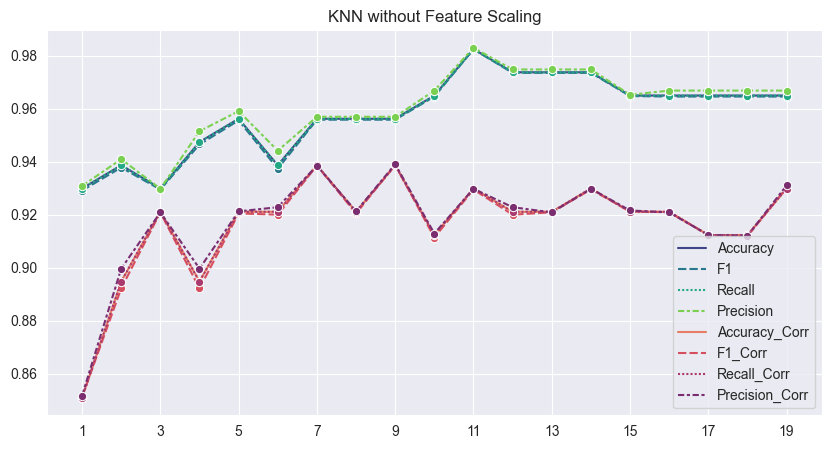

In [164]:
calculate(X_train, X_test, y_train, y_test, X_corr_train, X_corr_test, 'KNN without Feature Scaling')

### With Min-Max Scaling

Max Accuracy: 0.9736842105263158, for K = 2
Max Accuracy: 0.956140350877193, for K = 5


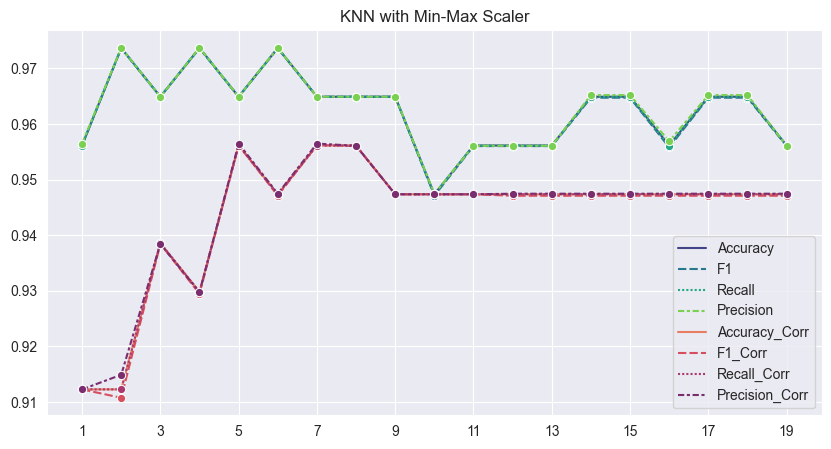

In [152]:
accuracy_scores = [np.array([0, 0, 0, 0])]
accuracy_scores2 = [np.array([0, 0, 0, 0])]
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k)
    model2 = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_mms, y_train)
    model2.fit(X_corr_train_mms, y_train)
    y_pred = model.predict(X_test_mms)
    y_pred2 = model2.predict(X_corr_test_mms)
    accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred)
    accuracy_scores.append(
        np.array([accuracy, f1, recall, precision])
    )
    accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred2)
    accuracy_scores2.append(
        np.array([accuracy, f1, recall, precision])
    )

evalution_metrics = pd.DataFrame(accuracy_scores, columns=['Accuracy', 'F1', 'Recall', 'Precision'])
evalution_metrics2 = pd.DataFrame(accuracy_scores2, columns=['Accuracy_Corr', 'F1_Corr', 'Recall_Corr', 'Precision_Corr'])
print(f'Max Accuracy: {evalution_metrics["Accuracy"].max()}, for K = {evalution_metrics["Accuracy"].idxmax()}')
print(f'Max Accuracy: {evalution_metrics2["Accuracy_Corr"].max()}, for K = {evalution_metrics2["Accuracy_Corr"].idxmax()}')

plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.lineplot(data=evalution_metrics[1:], marker='o', palette=sns.color_palette('viridis', n_colors=4)).set_xticks(range(1, 20, 2))
sns.lineplot(data=evalution_metrics2[1:], marker='o', palette=sns.color_palette('flare', n_colors=4)).set_xticks(range(1, 20, 2))
plt.title('KNN with Min-Max Scaler')
plt.show()

### With Standard Scaling

Max Accuracy: 0.9649122807017544, for K = 9
Max Accuracy: 0.956140350877193, for K = 7


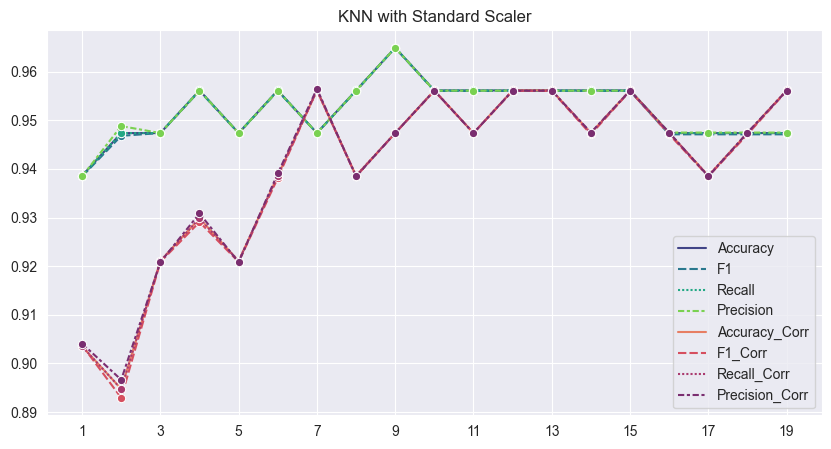

In [153]:
accuracy_scores = [np.array([0, 0, 0, 0])]
accuracy_scores2 = [np.array([0, 0, 0, 0])]
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k)
    model2 = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_ss, y_train)
    model2.fit(X_corr_train_ss, y_train)
    y_pred = model.predict(X_test_ss)
    y_pred2 = model2.predict(X_corr_test_ss)
    accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred)
    accuracy_scores.append(
        np.array([accuracy, f1, recall, precision])
    )
    accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred2)
    accuracy_scores2.append(
        np.array([accuracy, f1, recall, precision])
    )

evalution_metrics = pd.DataFrame(accuracy_scores, columns=['Accuracy', 'F1', 'Recall', 'Precision'])
evalution_metrics2 = pd.DataFrame(accuracy_scores2, columns=['Accuracy_Corr', 'F1_Corr', 'Recall_Corr', 'Precision_Corr'])
print(f'Max Accuracy: {evalution_metrics["Accuracy"].max()}, for K = {evalution_metrics["Accuracy"].idxmax()}')
print(f'Max Accuracy: {evalution_metrics2["Accuracy_Corr"].max()}, for K = {evalution_metrics2["Accuracy_Corr"].idxmax()}')

plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.lineplot(data=evalution_metrics[1:], marker='o', palette=sns.color_palette('viridis', n_colors=4)).set_xticks(range(1, 20, 2))
sns.lineplot(data=evalution_metrics2[1:], marker='o', palette=sns.color_palette('flare', n_colors=4)).set_xticks(range(1, 20, 2))
plt.title('KNN with Standard Scaler')
plt.show()

In [160]:
evalution_metrics[9]

,Accuracy,F1,Recall,Precision
0,0.0000,0.0000,0.0000,0.0000
1,0.9561,0.9562,0.9561,0.9565
2,0.9561,0.9558,0.9561,0.9569
3,0.9649,0.9649,0.9649,0.9649
4,0.9649,0.9649,0.9649,0.9649
5,0.9649,0.9649,0.9649,0.9649
6,0.9561,0.9560,0.9561,0.9561
7,0.9561,0.9560,0.9561,0.9561
8,0.9649,0.9647,0.9649,0.9652
9,0.9561,0.9560,0.9561,0.9561


## PCA
### With Min-Max Scaling
Let's check if outliers are significant.

Max Accuracy for n_components=2: 0.9825, for K = 10
Max Accuracy for n_components=3: 0.9649, for K = 7
Max Accuracy for n_components=4: 0.9474, for K = 5
Max Accuracy for n_components=5: 0.9474, for K = 4
Max Accuracy for n_components=6: 0.9649, for K = 12
Max Accuracy for n_components=7: 0.9737, for K = 5
Max Accuracy for n_components=8: 0.9649, for K = 4
Max Accuracy for n_components=9: 0.9649, for K = 3
Max Accuracy for n_components=10: 0.9737, for K = 19
Max Accuracy for n_components=11: 0.9737, for K = 10
Max Accuracy for n_components=12: 0.9649, for K = 5
Max Accuracy for n_components=13: 0.9649, for K = 3
Max Accuracy for n_components=14: 0.9649, for K = 3
Max Accuracy for n_components=15: 0.9649, for K = 3
Max Accuracy for n_components=16: 0.9737, for K = 8
Max Accuracy for n_components=17: 0.9649, for K = 2
Max Accuracy for n_components=18: 0.9825, for K = 2
Max Accuracy for n_components=19: 0.9649, for K = 1
Max Accuracy for n_components=20: 0.9649, for K = 1
Max Accuracy for

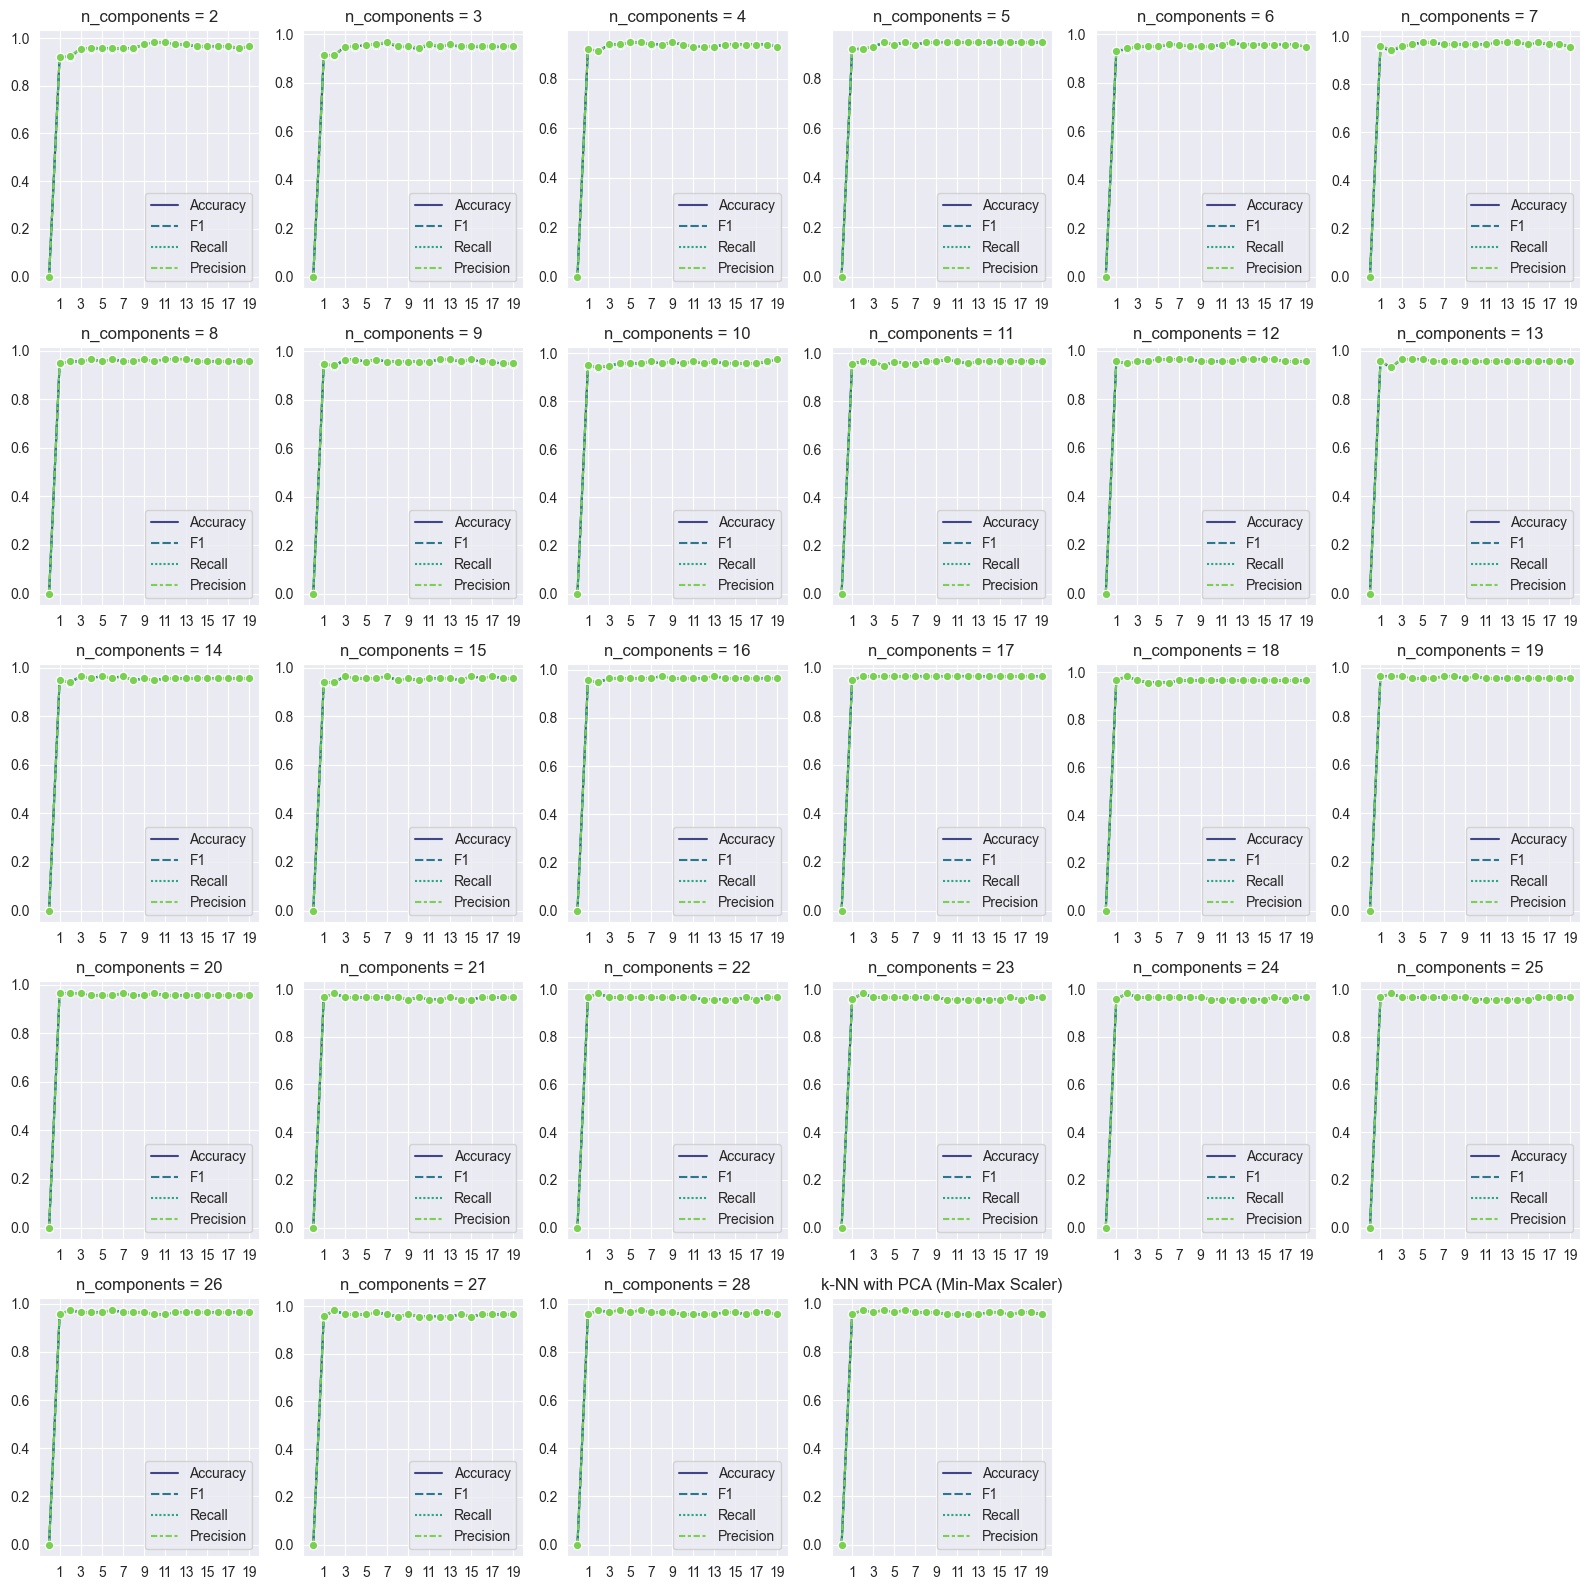

In [154]:
tmp_pca = [0,0,0,0,0,0]
evalution_metrics = []
import warnings
for n in range(2, 30):
    pca = PCA(n_components=n)
    pca.fit(X_train)

    warnings.filterwarnings("ignore")
    X_train_pca = pca.transform(X_train_mms)
    X_test_pca = pca.transform(X_test_mms)

    accuracy_scores = [np.array([0, 0, 0, 0])]
    for k in range(1, 20):
        knn_pca = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn_pca.fit(X_train_pca, y_train)
        y_pred = knn_pca.predict(X_test_pca)
        accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred)
        if tmp_pca[0] < accuracy:
            tmp_pca = np.array([accuracy, f1, recall, precision, auc, cm])
        accuracy_scores.append(
            np.array([accuracy, f1, recall, precision, auc, cm])
        )
    evalution_metrics.append(pd.DataFrame(accuracy_scores, columns=['Accuracy', 'F1', 'Recall', 'Precision', 'AUC', 'Confusion Matrix']))
score.append(tmp_pca)
plt.figure(figsize=(16, 16))
sns.set_style("darkgrid")

for i in range(len(evalution_metrics)):
    print(f'Max Accuracy for n_components={i+2}: {evalution_metrics[i]["Accuracy"].max()}, for K = {evalution_metrics[i]["Accuracy"].idxmax()}')

    plt.subplot(5, 6, i+1)  # Subplot indexing starts from 1
    sns.lineplot(data=evalution_metrics[i, :4], marker='o', palette=sns.color_palette('viridis', n_colors=4)).set_xticks(range(1, 20, 2))
    plt.title(f"n_components = {i + 2}") # Distribution of the column

plt.tight_layout()
plt.title("k-NN with PCA (Min-Max Scaler)")
plt.show()

### With Standard Scaling

Max Accuracy for n_components=2: 0.9824561403508771, for K = 10


TypeError: list indices must be integers or slices, not tuple

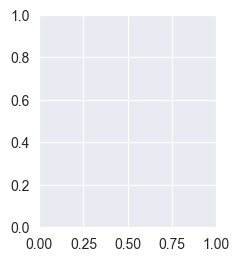

In [17]:
tmp_pca = [0,0,0,0,0,0]
evalution_metrics = []
import warnings
for n in range(2, 30):
    pca = PCA(n_components=n)
    pca.fit(X_train)

    warnings.filterwarnings("ignore")
    X_train_pca = pca.transform(X_train_ss)
    X_test_pca = pca.transform(X_test_ss)

    accuracy_scores = [np.array([0, 0, 0, 0])]
    for k in range(1, 20):
        knn_pca = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn_pca.fit(X_train_pca, y_train)
        y_pred = knn_pca.predict(X_test_pca)
        accuracy, f1, recall, precision, auc, cm = evaluate(y_test, y_pred)
        if tmp_pca[0] < accuracy:
            tmp_pca = np.array([accuracy, f1, recall, precision, auc, cm])
        accuracy_scores.append(
            np.array([accuracy, f1, recall, precision, auc, cm])
        )
    evalution_metrics.append(pd.DataFrame(accuracy_scores, columns=['Accuracy', 'F1', 'Recall', 'Precision', 'AUC', 'Confusion Matrix']))
score.append(tmp_pca)

plt.figure(figsize=(16, 16))
sns.set_style("darkgrid")

for i in range(len(evalution_metrics)):
    print(f'Max Accuracy for n_components={i+2}: {evalution_metrics[i]["Accuracy"].max()}, for K = {evalution_metrics[i]["Accuracy"].idxmax()}')

    plt.subplot(5, 6, i+1)  # Subplot indexing starts from 1
    sns.lineplot(data=evalution_metrics[i, :4], marker='o', palette=sns.color_palette('viridis', n_colors=4)).set_xticks(range(1, 20, 2))
    plt.title(f"n_components = {i + 2}") # Distribution of the column

plt.tight_layout()
plt.title("k-NN with PCA (Standard Scaler)")
plt.show()

In [ ]:
pd.DataFrame(score,
    index=['Min-Max Scaler', 'Min-Max Scaler Corr', 'Standard Scaler', 'Standard Scaler Corr', 'PCA Min-Max Scaler', 'PCA Min-MAx Scaler Corr', 'PCA Standard Scaler', 'PCA Standard Scaler Corr'], 
    columns=['Accuracy', 'F1', 'Recall', 'Precision', 'AUC', 'Confusion Matrix'])

,Accuracy,F1,Recall,Precision,AUC,Confusion Matrix
Min-Max Scaler,0.982456,0.982369,0.982456,0.982937,0.976744,"[[71, 0], [2, 41]]"
Min-Max Scaler Corr,0.956140,0.955801,0.956140,0.956905,0.946446,"[[70, 1], [4, 39]]"
Standard Scaler,0.973684,0.973621,0.973684,0.973719,0.969702,"[[70, 1], [2, 41]]"
Standard Scaler Corr,0.982456,0.982456,0.982456,0.982456,0.981330,"[[70, 1], [1, 42]]"
PCA Min-Max Scaler,0.964912,0.964738,0.964912,0.965205,0.958074,"[[70, 1], [3, 40]]"
PCA Min-MAx Scaler Corr,0.964912,0.964738,0.964912,0.965205,0.958074,"[[70, 1], [3, 40]]"
PCA Standard Scaler,0.991228,0.991207,0.991228,0.991350,0.988372,"[[71, 0], [1, 42]]"
PCA Standard Scaler Corr,0.982456,0.982456,0.982456,0.982456,0.981330,"[[70, 1], [1, 42]]"
